# Spotify Songplays Exploration and Music Recommendation

In this notebook I explore the Spotify songplays from the subset of the #nowlplaying dataset (Zangerle et al. 2014).
The analysis aims to first explore the provided dataset, then to examplify a simple approach to cluster users based on their music preferences and finally recommend new songs to some random user.

For me the fun part of this analysis is that it was possible to listen to the artists which I stumbled across and was able to discover many new tunes.

I am happy to share some of my insight in this notebook.

## Structure

+ **I. Data Import**
+ **II. Data Description**
+ **III. Most Popular Tracks, Artists & Playlists**
+ **IV. Cluster Users into Music Genre Preferences**
+ **V. Music Recommandation**
+ **VI. Conclusion**

## Packages


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# I. Data Import

Let's read in the data and see what it looks like.

In [6]:
path = "/Users/lilianvalin/.cache/kagglehub/datasets/andrewmvd/spotify-playlists/versions/1/spotify_dataset.csv"

In [7]:
spotify_df = pd.read_csv(path, 
                         skiprows=1,
                         names=['user_id', 'artistname', 'trackname', 'playlistname'],
                         on_bad_lines='skip')

spotify_df.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010


# II. Data Description

Let's first look at some key figures of the provided dataset.

+ **~13 Mio.** songplays in the data
+ **15,918** unique users
+ **289,821** unique artists


In [8]:
spotify_df.describe()

,user_id,artistname,trackname,playlistname
count,12891680,12858108,12891592,12890434
unique,15918,289820,2032043,157504
top,4398de6902abde3351347b048fcdc287,Daft Punk,Intro,Starred
freq,295275,36086,6676,1337085


### User with most Songplays

In [23]:
plays_per_user.head()

,total_plays,count
0,4398de6902abde3351347b048fcdc287,295275
1,7ee2b92c5bcf6133b8132363e5bda960,90630
2,99deafd9b792af8e6a535483088faef2,65909
3,fa849dabeb14a2800ad5130907fc5018,60713
4,6b85a8076b4f3b1036ef15f09e2feeeb,39669



So apparently one user has almost **300,000 songplays** posted from his Twitter account!

This appears more than insane...

Assuming a song length of 3 minutes this would corresponst to **more than 600 days of constant music listening**.

Must be a serious music lover, but maybe just a corporate marketing account, or spam.

### Songplays of most active User

Just out of curiosity, let's see what this user has been listening to all the time.

In [24]:
def plot_wordcloud_from_ranking(ranking_dict, max_words=100, plot_title=''):
    
    wc = WordCloud(background_color="white", 
                   max_words=max_words,
                   random_state=1,
                   colormap='gnuplot',
                    )
    # generate word cloud
    wc.generate_from_frequencies(ranking_dict)
    
    #if plot_title is not None:
    plt.title(plot_title, fontsize = 28)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    

Most played Artist:
M83 - 143 plays



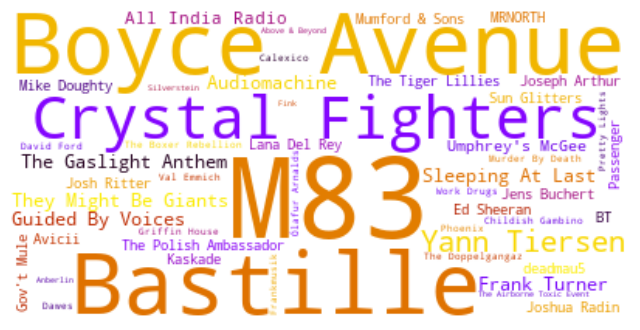

In [25]:
## Top song from specific user
user_id_of_interest = '4398de6902abde3351347b048fcdc287'

plays_of_user = spotify_df.loc[spotify_df.user_id == user_id_of_interest]

top_artists_of_user = pd.DataFrame(plays_of_user.artistname.value_counts()).reset_index()
top_artists_of_user.columns = ['artistname', 'plays']
# Dict needed for Wordcloud function
top_artists_of_user_dict = top_artists_of_user.set_index('artistname').to_dict()['plays']
# Basic description
print("Most played Artist:")
print("{0} - {1} plays".format(top_artists_of_user.loc[0, 'artistname'], f'{top_artists_of_user.loc[0, "plays"]:,}'))
print()
# Plot as Wordcloud
plot_wordcloud_from_ranking(top_artists_of_user_dict, max_words=50)

With almost **22,000 unique artists** and almost over **300,000 total songplays** this user still seems to have a very diverse taste of music. Most of his favorite artists seem to resemble the charts from the period around 2015.

# III. Most Popular Tracks, Artists & Playlists

Now let's also look deeper into the most popular music in the data.

## 1. Top Tracks

It's not clear when the provided Spotify plays have been recorded and over what time span. Looking at the most popular tracks none of them was released after 2013. So let's assume that the data resembles the songplays during this year. 

So here we can see the hottest tunes from almost 10 years ago.

In [26]:
top_song = (spotify_df
            .groupby(['artistname','trackname'])
            .agg({'user_id':['count', 'nunique']})
            .sort_values(('user_id','count'), ascending=False)
           )
top_song.columns = ['plays','listeners']
top_song.head(10)

,,plays,listeners
artistname,trackname,,
M83,Midnight City,2609,1890
Daft Punk,Get Lucky - Radio Edit,2341,1836
Imagine Dragons,Radioactive,2336,1815
Of Monsters and Men,Little Talks,2254,1681
Avicii,Wake Me Up,2242,1695
Lorde,Royals,2219,1723
The Lumineers,Ho Hey,2180,1634
Macklemore & Ryan Lewis,Can't Hold Us - feat. Ray Dalton,2066,1583
Bastille,Pompeii,2014,1523


## 2. Top Artists

Number of Artists:
289,820

Most played Artist:
Daft Punk - 36,086 plays



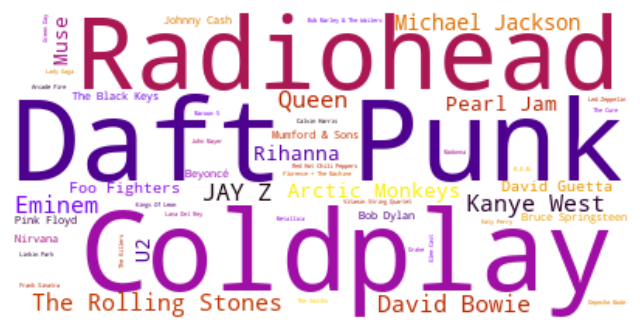

In [27]:
# Top 10 artists listened to by user with most songplays
top_artists = pd.DataFrame(spotify_df.artistname.value_counts()).reset_index()
top_artists.columns = ['artistname', 'plays']
# Dict needed for Wordcloud function
top_artists_dict = top_artists.set_index('artistname').to_dict()['plays']

# Basic description
print("Number of Artists:")
print(f'{len(top_artists):,}')
print()

print("Most played Artist:")
print("{0} - {1} plays".format(top_artists.loc[0, 'artistname'], f'{top_artists.loc[0, "plays"]:,}'))
print()
# Plot as Wordcloud
plot_wordcloud_from_ranking(top_artists_dict, max_words=50)

## 3. Top Genres

For now it is not possible to identify the Genres of the tracks, but the names of Spotify playlists might include some information about the included genres: 

Number of Playlists:
157,504

Most played Playlist:
Starred - 1,337,085 plays



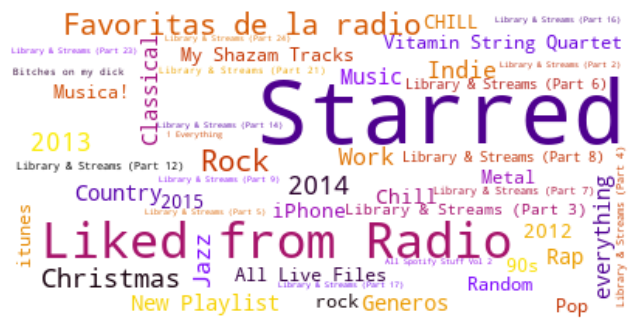

In [28]:
# Top 10 artists listened to by user with most songplays
top_playlists = pd.DataFrame(spotify_df.playlistname.value_counts()).reset_index()
top_playlists.columns = ['playlistname', 'plays']
# Dict needed for Wordcloud function
top_playlists_dict = top_playlists.set_index('playlistname').to_dict()['plays']

# Basic description
print("Number of Playlists:")
print(f'{len(top_playlists):,}')
print()

print("Most played Playlist:")
print("{0} - {1} plays".format(top_playlists.loc[0, 'playlistname'], f'{top_playlists.loc[0, "plays"]:,}'))
print()
# Plot as Wordcloud
plot_wordcloud_from_ranking(top_playlists_dict, max_words=50)

# IV. Cluster Users into Music Genre Preferences

## 1. Reduce Dimension of Songplays Data

First, we want reduce the number of considered artist and users. 
User with very few songplays and artists with few listeners introduce too much noise into our feature space, which might lead to worse results. Also with fewer instances the runtimes of the clustering algorithm will be reduced.

### a) How many of the 289,821 artists should we consider?

In [29]:
# Names for the x-axis
exp10_series = 10 ** np.array(range(6))
# subtract 1 as we start count at 0
idx = exp10_series - 1

top_artists = spotify_df.groupby('artistname').count().sort_values('user_id', ascending=False)
top_artists = top_artists[['user_id']]
top_artists.columns = ['plays']

artists_popularity = top_artists.copy()
artists_popularity['cumulated_sum'] = artists_popularity['plays'].cumsum()
artists_popularity['share'] = artists_popularity['cumulated_sum'] / artists_popularity['plays'].sum()

artist_plays_dist = (artists_popularity
                     .reset_index()
                     .iloc[idx][['share']]
                     .reset_index()
                     .rename(columns={'index':'rank'})
                    )
artist_plays_dist['rank'] = artist_plays_dist['rank'] + 1

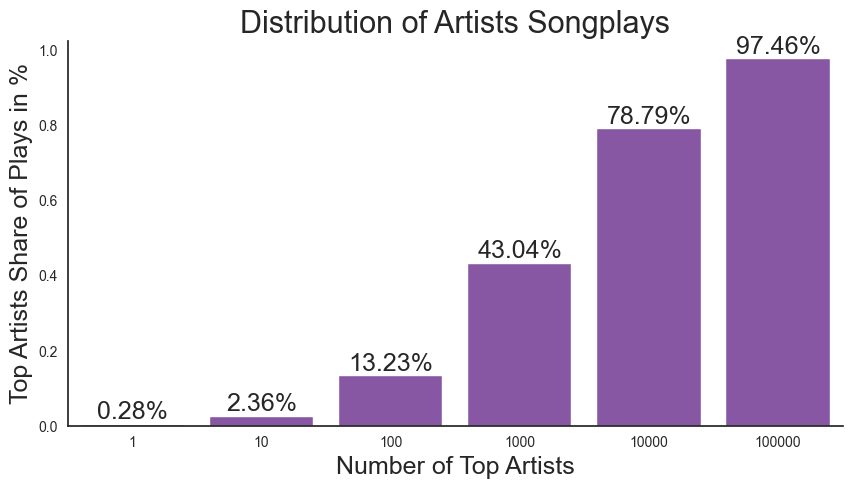

In [30]:
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(10,5))    

sns.barplot(data=artist_plays_dist, 
            x='rank', 
            y='share', 
            color='#8b4ab0')

sns.despine()
sns.set(font_scale = 1.5)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2%'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

                   
ax.set_title('Distribution of Artists Songplays', fontsize=22)
ax.set_xlabel('Number of Top Artists', fontsize=18)
ax.set_ylabel('Top Artists Share of Plays in %', fontsize=18)
_ = ax.legend([],[], frameon=False)

We can see that by using the **1,000 most popular artists** in the data, we are already able to cover over **40% of the songplays** in the data.
Using the **10,000 most popular artists** we are able to cover almost **80% of the songplays**.

Probably a save bet is **consider 50% of the songplays**, so we need to consider a bit more than the 1,000 top artists.

In [31]:
number_considered_artists = len(artists_popularity) - (artists_popularity['share'] > 0.5).sum()
print(f'{number_considered_artists:,} artists to consider')

1,527 artists to consider


Those 1,528 artists will now be used to derive the music genre preferences of the users.

### b) Filter out User with few Songplays

We also want to reduce the number of considered users. In the first exploration we already saw that we have quite active users, so we should be fine to set a high threshold of plays for our considered users. 


For the further analysis we only include users with at least 10 songplays of the considered top artists.

In [32]:
## Filter the Songplays
minimum_relevant_artist_plays = 10

#only keep plays most popular artists for further analysis
considered_artist_list = artists_popularity.reset_index().iloc[:number_considered_artists]['artistname']
relevant_plays = spotify_df[spotify_df.artistname.isin(considered_artist_list)]

# only keep users with minimum number of plays for considered artists
relevant_user_id_counts = relevant_plays.groupby('user_id').agg({'artistname':'nunique'})
relevant_user_ids = relevant_user_id_counts[relevant_user_id_counts.iloc[:, 0] >= minimum_relevant_artist_plays].index
# filter out songplays of users with too few songplays
relevant_plays = relevant_plays.loc[relevant_plays.user_id.isin(relevant_user_ids)]

print(f'{len(relevant_user_ids):,} included users')
print()
print(f'{len(relevant_plays):,} remaining songplays')

12,606 included users

6,337,701 remaining songplays


## 2. Transform Songplays Table

To apply the clustering algorithm we need to define the feature space in which the instances are supposed to be clustered.

We transform the data into a indicator matrix where each row depicts one user and each column one of the 1,528 artists we chose to consider.
Each row than indicates whether the user has listened to the specific artist or not.


|       | Artist1 | Artist2 | Artist3 | ... |
|-------|---------|---------|---------|-----|
| User1 | 0       | 1       | 0       | ... |
| User2 | 0       | 1       | 1       | ... |
| User3 | 1       | 0       | 0       | ... |
| ...   | ...     | ...     | ...     | ... |


So in this example User1 has at least once listened to Artist2, but not to Artist1 and Artist3.

In [33]:
user_artist_matrix = (relevant_plays
           .pivot_table(values=['trackname'],index=['user_id'],columns=['artistname'], aggfunc='count')
           .fillna(0)
          )
# transform counts into indicators [0,1]
user_artist_matrix = (user_artist_matrix / user_artist_matrix).fillna(0).astype('int')
user_artist_matrix.head(10)

trackname                              \
artistname                        2 Chainz 2Pac 3 Doors Down 311 3OH!3   
user_id                                                                  
00055176fea33f6e027cd3302289378b         0    0            0   0     0   
0007f3dd09c91198371454c608d47f22         0    0            0   0     0   
000c11a16c89aa4b14b328080f5954ee         0    0            0   0     0   
00123e0f544dee3ab006aa7f1e5725a7         0    0            0   0     0   
00139e9cb50fb309549e1561b476226d         0    0            0   0     0   
0019363a0d57e94d39988c31eeb8d015         0    0            0   0     0   
001c4e5b73eca68ee9756bb0c7d2f855         0    0            0   0     0   
0025022960e5f0d7d01af5d840014594         0    1            0   0     0   
002544ea04896444d79d3e4a7e073422         0    0            0   0     0   
0028736f2b131fc698d959ca9adddc4b         0    0            0   0     0   

                                                              \
artistname                       5 Seconds Of Summer 50 Cent   
user_id                                                        
00055176fea33f6e027cd3302289378b                   1       0   
0007f3dd09c91198371454c608d47f22                   0       0   
000c11a16c89aa4b14b328080f5954ee                   0       0   
00123e0f544dee3ab006aa7f1e5725a7                   0       0   
00139e9cb50fb309549e1561b476226d                   0       0   
0019363a0d57e94d39988c31eeb8d015                   0       0   
001c4e5b73eca68ee9756bb0c7d2f855                   0       0   
0025022960e5f0d7d01af5d840014594                   0       0   
002544ea04896444d79d3e4a7e073422                   0       1   
0028736f2b131fc698d959ca9adddc4b                   0       0   

                                                                  \
artistname                       A Day To Remember A Fine Frenzy   
user_id                                                            
00055176fea33f6e027cd3302289378b                 0             0   
0007f3dd09c91198371454c608d47f22                 0             0   
000c11a16c89aa4b14b328080f5954ee                 0             0   
00123e0f544dee3ab006aa7f1e5725a7                 0             0   
00139e9cb50fb309549e1561b476226d                 0             0   
0019363a0d57e94d39988c31eeb8d015                 0             0   
001c4e5b73eca68ee9756bb0c7d2f855                 0             0   
0025022960e5f0d7d01af5d840014594                 0             0   
002544ea04896444d79d3e4a7e073422                 0             0   
0028736f2b131fc698d959ca9adddc4b                 0             0   

                                                    ...                       \
artistname                       A Great Big World  ... Zedd Zero 7 Zoé a-ha   
user_id                                             ...                        
00055176fea33f6e027cd3302289378b                 0  ...    0      0   0    0   
0007f3dd09c91198371454c608d47f22                 0  ...    0      0   0    0   
000c11a16c89aa4b14b328080f5954ee                 0  ...    1      0   1    0   
00123e0f544dee3ab006aa7f1e5725a7                 0  ...    0      0   0    0   
00139e9cb50fb309549e1561b476226d                 0  ...    0      1   0    1   
0019363a0d57e94d39988c31eeb8d015                 0  ...    0      0   0    0   
001c4e5b73eca68ee9756bb0c7d2f855                 0  ...    0      0   0    0   
0025022960e5f0d7d01af5d840014594                 0  ...    0      1   0    0   
002544ea04896444d79d3e4a7e073422                 0  ...    0      0   0    0   
0028736f2b131fc698d959ca9adddc4b                 0  ...    0      0   0    0   

                                                                      \
artistname                       alt-J blink-182 deadmau5 tUnE-yArDs   
user_id                                                                
00055176fea33f6e027cd3302289378b     0         1        0          0   
0007f3dd09c91198371454c

#### Sparsity of Matrix

In [37]:
non_zero_values = user_artist_matrix.values.sum()
matrix_size = user_artist_matrix.shape[0] * user_artist_matrix.shape[1]

share_of_non_zero = non_zero_values / matrix_size
print(f'{share_of_non_zero:.2%} non-zero values in matrix')

6.34% non-zero values in matrix


## 3. k-means Clustering
### a) Determine best value for k parameter

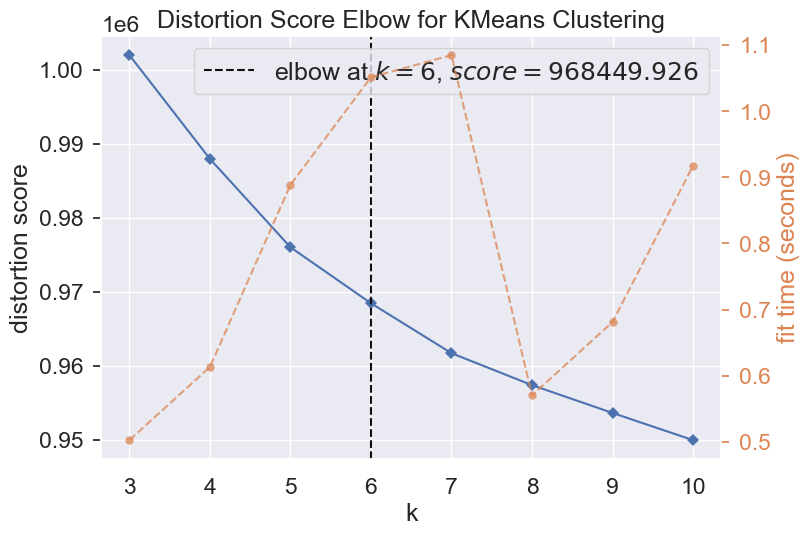

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=range(3,11, 1))

visualizer.fit(user_artist_matrix)
best_k = visualizer.elbow_value_
visualizer.show()

### b) Cluster Users into k Groups

In [39]:
k_means_est = KMeans(n_clusters=best_k, random_state=123)

k_means_est.fit(user_artist_matrix)

KMeans(n_clusters=np.int64(6), random_state=123)

In [40]:
## Append the assigned cluster to each user
cluster_labels = k_means_est.labels_

user_clusters = user_artist_matrix.reset_index()[['user_id']]
# let's start counting at 1
user_clusters['cluster'] = cluster_labels + 1

## 4. Evaluate derived Clusters

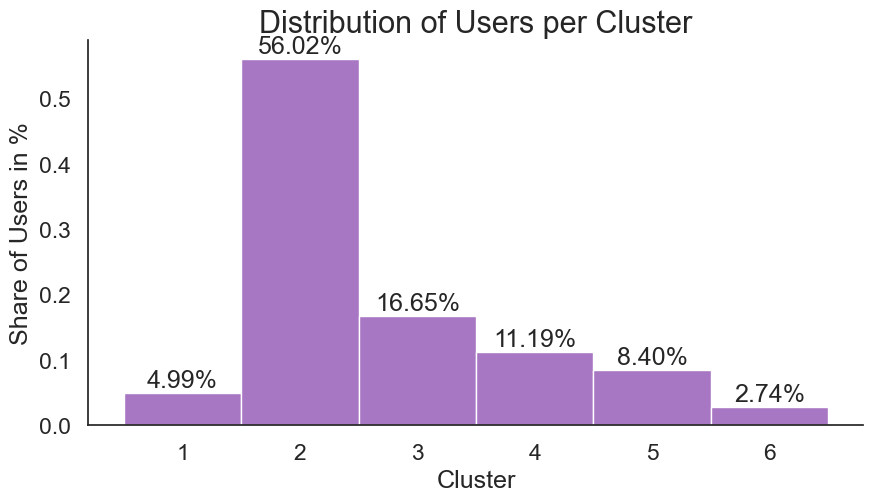

In [41]:
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(10,5))    

sns.histplot(data=user_clusters, 
             x="cluster",
             color='#8b4ab0',
             stat="probability",
             discrete=True
            )

sns.despine()
sns.set(font_scale = 1.5)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2%'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
                   
ax.set_title('Distribution of Users per Cluster', fontsize=22)
ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Share of Users in %', fontsize=18)
_ = ax.legend([],[], frameon=False)

### Most Liked Artists in each cluster

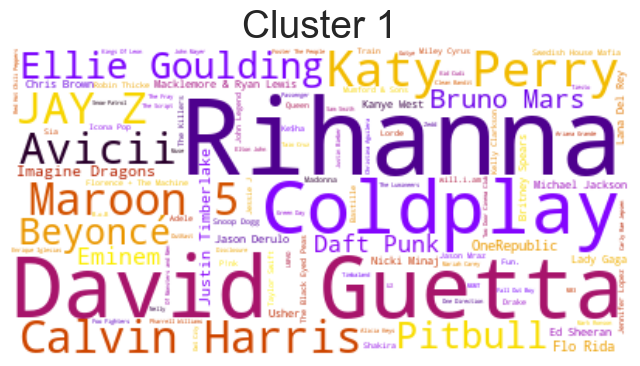

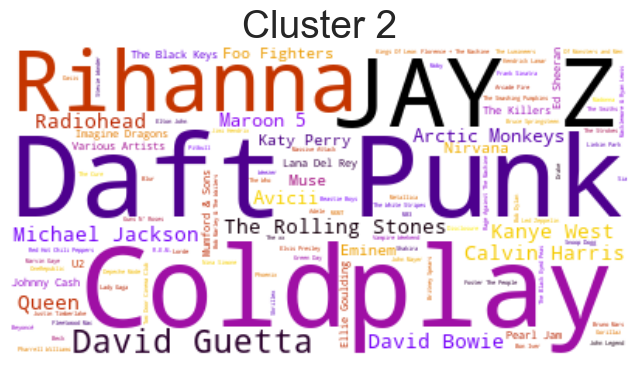

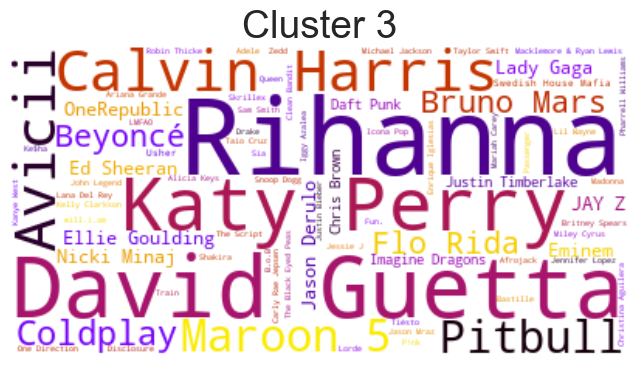

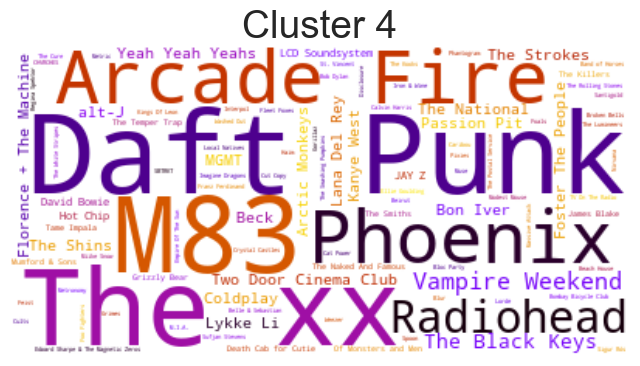

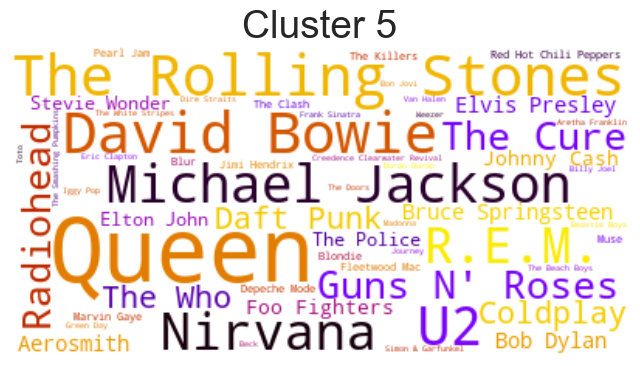

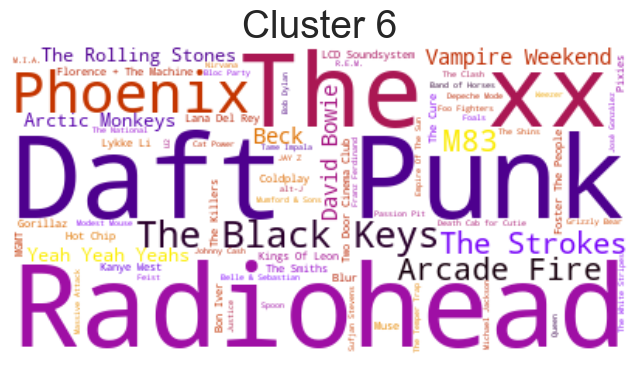

In [42]:
## Total artists popularity
artist_popularity = pd.DataFrame(user_artist_matrix.sum() / user_artist_matrix.to_numpy().sum(), columns=['total_popularity']).reset_index().iloc[:, 1:]

## For each Cluster get the top artists
for c in sorted(user_clusters.cluster.unique()):
    uids = user_clusters.loc[user_clusters.cluster == c, 'user_id']
    cluster_user = user_artist_matrix.loc[list(user_artist_matrix.reset_index().user_id.isin(uids))]
    
    new_col_name = 'cluster'+str(c)+'_popularity'
    cluster_popularity = pd.DataFrame(cluster_user.sum() / cluster_user.to_numpy().sum(), columns=[new_col_name]).reset_index().iloc[:, 1:]
    #print("Cluster " + str(c))
    cluster_popularity_dict = cluster_popularity.set_index('artistname').to_dict()[new_col_name]
    plot_wordcloud_from_ranking(cluster_popularity_dict, plot_title="Cluster " + str(c))
    print()
    
    artist_popularity = pd.merge(artist_popularity, cluster_popularity, how='inner', on='artistname')

### Most Liked Artists in each cluster 2nd Approach

The most popular are most likely going to be present in each cluster. That's why Daft Punk appears so frequently.
However, we are interested in the artists which set apart the music taste of the users in the cluster - not just stuff everybody listens to...

So next we calculate the artist populatity in each cluster by taking the frequency this artist in the cluster and then subtracting this artists total popularity. 
This should highlight distinct music preferences in each cluster.

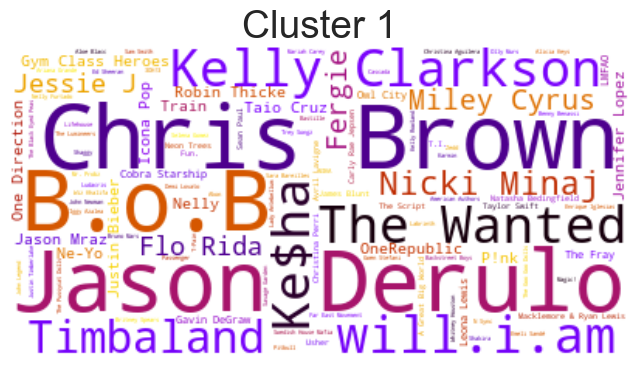

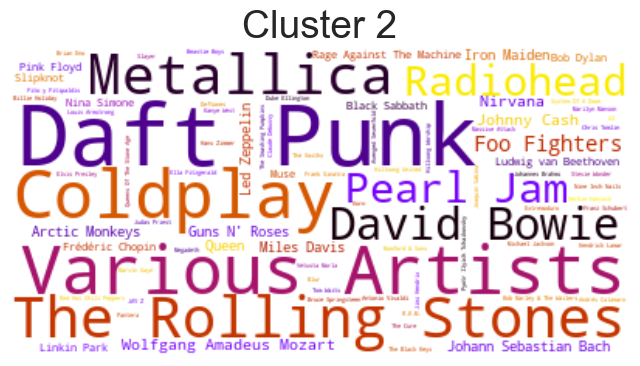

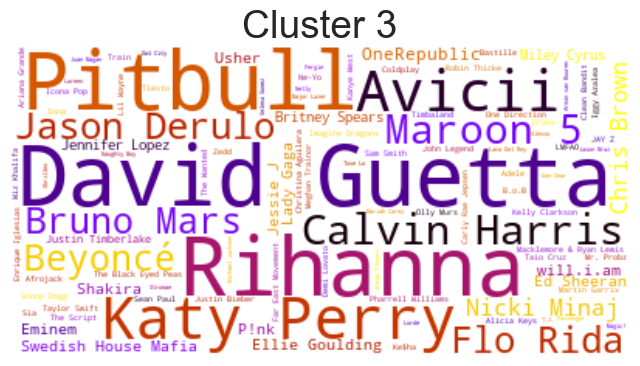

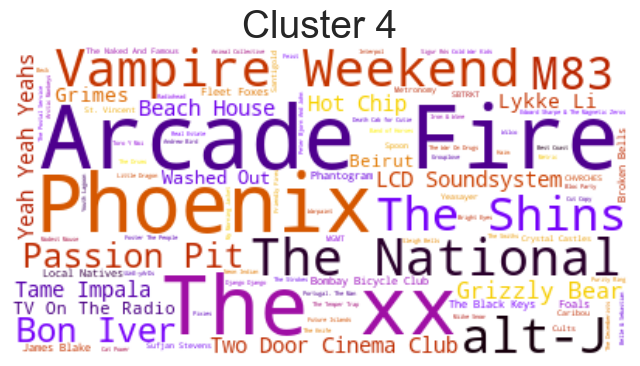

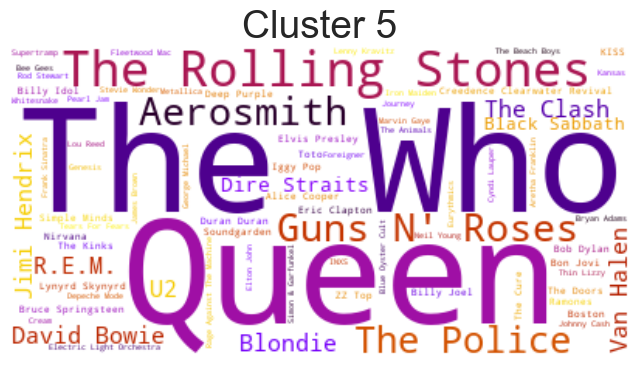

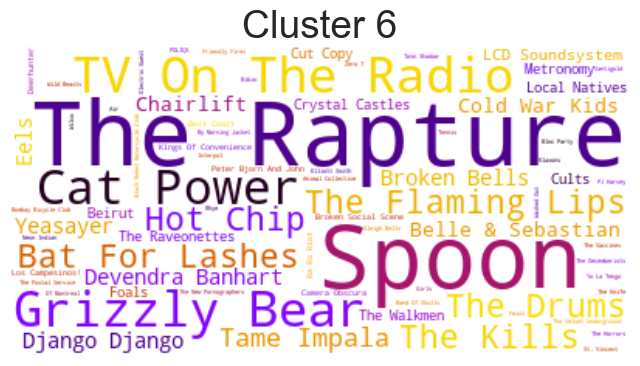

In [43]:
for cluster_col in artist_popularity.iloc[:, 2:].columns:
    new_col_name = cluster_col + '_net'
    artist_popularity[new_col_name] = artist_popularity[cluster_col] - artist_popularity['total_popularity']
    
    most_liked_artists = artist_popularity.loc[:, ['artistname', cluster_col+ '_net']].sort_values(by= cluster_col+ '_net',ascending=False)
    
    cluster_name_str = cluster_col.replace('_popularity','').replace('cluster', 'Cluster ')
    
    cluster_popularity_dict = most_liked_artists.set_index('artistname').to_dict()[new_col_name]
    plot_wordcloud_from_ranking(cluster_popularity_dict, plot_title=cluster_name_str)
    print()

# V. Music Recommandation

## 1. Music Preferences in the Cluster

We can now use the derived clusters to recommend new music to users.

The assumption is that users in the same cluster share a similar taste in music. So we calculate the most popular songs in each cluster and then recommend a user the songs which he has not yet listened to.

Here we pick a random user and see which songs we could recommend to him.

In [44]:
def get_top_songs_of_user(songplays_data, user_id):
    
    top_songs = (songplays_data
     .loc[songplays_data.user_id == user_id]
     .groupby(['artistname', 'trackname'])
     .agg({'user_id':'count'})
     .sort_values('user_id', ascending=False)
     .rename(columns={'user_id':'plays'})
    )

    top_songs['plays_share'] = top_songs['plays'] / top_songs['plays'].sum()
    
    top_songs = top_songs.reset_index()
    
    return top_songs


def get_songs_recommendations(top_user_plays, top_recommender_plays):
    recommended_songs = pd.merge(top_recommender_plays, 
                                         top_user_plays, 
                                         on=['artistname','trackname'], 
                                         how='left',
                                        suffixes=('','_user'))
    # Filter out already listened to tracks
    recommended_songs = (recommended_songs
                            .loc[recommended_songs['plays_user'].isna()]
                            .drop(columns=['plays_user', 'plays_share_user'])
                        )

    return recommended_songs

### a) Top Songs of User

Pick some random user from the data.

In [45]:
seed_value = 123 # -> change to explore for different user
random_user_id = relevant_plays.user_id.sample(1, random_state=seed_value).iloc[0]
print("User ID of random User:")
print(random_user_id)

top_songs_of_user = get_top_songs_of_user(spotify_df, random_user_id)
top_songs_of_user.head()

User ID of random User:
a50bae5e2f53d4350a38eea8a9f8cb49


,artistname,trackname,plays,plays_share
0,Danzig,Mother,1,0.025641
1,Rage Against The Machine,Take The Power Back - Live,1,0.025641
2,Rage Against The Machine,Killing In The Name - Remastered,1,0.025641
3,Rage Against The Machine,Know Your Enemy,1,0.025641
4,Rage Against The Machine,Know Your Enemy - Demo,1,0.025641


### b) Top Songs in Cluster of User

In [48]:
# Get the cluster of the random user
cluster_of_random_user = user_clusters.loc[user_clusters.user_id == random_user_id, 'cluster'].iloc[0]

# Filter users in the same cluster
users_in_cluster = user_clusters.loc[user_clusters['cluster'] == cluster_of_random_user, ['user_id']].reset_index(drop=True)

# Merge with songplays data
cluster_songplays = pd.merge(spotify_df, users_in_cluster, on='user_id')

# Aggregate songplays by artist and track
top_songs_in_cluster = (
    cluster_songplays
    .groupby(['artistname', 'trackname'])
    .agg({'user_id': 'count'})
    .sort_values('user_id', ascending=False)
    .rename(columns={'user_id': 'plays'})
)

# Calculate play share
top_songs_in_cluster['plays_share'] = top_songs_in_cluster['plays'] / top_songs_in_cluster['plays'].sum()

# Get the top 100 songs in the cluster
top_songs_in_cluster = top_songs_in_cluster.head(100)

# Display the result
top_songs_in_cluster.head()

MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [49]:
# Filter out songs which the user already listened to
recommendations_from_cluster = get_songs_recommendations(top_songs_of_user, top_songs_in_cluster)

recommendations_from_cluster.head(10)

NameError: name 'top_songs_in_cluster' is not defined

## 2. Individual Doppelgänger Recommendations

Using the User-Artists-listened-to indicator matrix, we can also look for specific users which share the same artists preferences. **We call those twin user Doppelgänger.**

Similar as in the in previous approach, we recommend the user the top songs of his Doppelgänger (which he has not yet listend to).

### a) Find Doppelgänger for the User

In [28]:
def get_doppelgaenger(user_artist_matrix, user_of_interest):
    """
        Return Series of User IDs with the most matches of artist plays with the user of interest
    """
    user_plays = user_artist_matrix.loc[user_of_interest]

    non_zero_idx = np.where(user_plays == 1)[0]

    doppelgaenger_matches = (user_artist_matrix
                                 .drop(user_of_interest)
                                 .iloc[:, non_zero_idx]
                                 .sum(axis=1)
                                 .sort_values(ascending=False)
                                 .to_frame()
                                 .rename(columns={0:'artist_matches'})
                            )
    
    doppelgaenger_matches['artist_matches_share'] = doppelgaenger_matches['artist_matches'] / user_plays.sum()
    
    return doppelgaenger_matches

In [29]:
# Users with most artists matches
user_doppelgaengers = get_doppelgaenger(user_artist_matrix, random_user_id)
user_doppelgaengers.head()

,artist_matches,artist_matches_share
user_id,,
6752faf971cd451d87b270621979e2d5,104,0.825397
be025481e694f545dbe01082e2ef7a67,88,0.698413
7ffae624f8f096dd429b1f7e78efb32b,86,0.682540
ed140fce438f59e6e07e5ee7bd726692,85,0.674603
f03b8551dfc40c7866e9a393371ef383,85,0.674603


So for this user we found someone who shares 83% songplays of artist in our considered feature space.
Looks a good fit for a Doppelgänger.

### b) Recommend Music from Doppelgänger

In [30]:
# Get the Doppelgaenger
doppelgaenger_id = user_doppelgaengers.iloc[0].name
top_songs_of_dopplegaenger = get_top_songs_of_user(spotify_df, doppelgaenger_id)
top_songs_of_dopplegaenger.head()

,artistname,trackname,plays,plays_share
0,Ed Sheeran,Thinking Out Loud,16,0.000964
1,Mark Ronson,Uptown Funk,16,0.000964
2,Pitbull,Time of Our Lives,15,0.000904
3,Ellie Goulding,"Love Me Like You Do - From Fifty Shades Of Grey""""",14,0.000843
4,Rihanna,FourFiveSeconds,14,0.000843


In [31]:
recommendations_from_doppelgaenger = get_songs_recommendations(top_songs_of_user, top_songs_of_dopplegaenger)
recommendations_from_doppelgaenger.head(10)

,artistname,trackname,plays,plays_share
0,Ed Sheeran,Thinking Out Loud,16,0.000964
1,Mark Ronson,Uptown Funk,16,0.000964
2,Pitbull,Time of Our Lives,15,0.000904
3,Ellie Goulding,"Love Me Like You Do - From Fifty Shades Of Grey""""",14,0.000843
4,Rihanna,FourFiveSeconds,14,0.000843
7,Walk the Moon,Shut Up and Dance,14,0.000843
8,Jason Derulo,Want To Want Me,14,0.000843
9,50 Cent,In Da Club,14,0.000843
10,Nicki Minaj,Truffle Butter,13,0.000783
11,Flo Rida,GDFR (feat. Sage The Gemini & Lookas),13,0.000783


# VI. Conclusion

The shortcoming of the approach is that we broke down our feature space to those users which listen to the most popular artists. This implies that we are not able to derive recommendations for users which have not listened to any of those artists. 

One might also argue that it is not the most famous artists who define ones music taste, but maybe the personal favorites songs, which no one else listens to. This would then make the Doppelgänger analysis more interesting, as you could find someone who shares a your very distinct music taste.

**Further Steps:**
+ do not reduce recommender system to most famous artists
+ consider the number of songplays for each artist when clustering
+ include song titles, playlists into user similarity metrics
+ experiment with different clustering algorithms

I hope you enjoyed this little music journey and were able to find some new music inspirations for your next coding sessions.

# References
+ Zangerle, Eva, Martin Pichl, Wolfgang Gassler, and Günther Specht. "# nowplaying music dataset: Extracting listening behavior from twitter." In Proceedings of the first international workshop on internet-scale multimedia management, pp. 21-26. 2014.